In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc
import skill_metrics as sm #https://github.com/PeterRochford/SkillMetrics/tree/master/skill_metrics
#from mpl_toolkits.basemap import Basemap
import pickle
from cmocean import cm
from salishsea_tools import visualisations as vis
import arrow
import glob
from scipy.io import loadmat
import xarray as xr
from salishsea_tools import (
viz_tools)

%matplotlib inline

In [20]:
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

nav_lon = (grid['nav_lon'][:])
nav_lat = (grid['nav_lat'][:])
jdf_x = 85; jdf_y = 325; jdf_col = 'teal'
jdf2_x = 50; jdf2_y = 370; jdf2_col = 'mediumaquamarine'
jdf3_x = 130; jdf3_y = 290; jdf3_col = 'lightseagreen'

cs_x = 250; cs_y = 500; cs_col = 'royalblue'
cs2_x = 280; cs2_y = 440; cs2_col = 'navy'
cs3_x = 220; cs3_y = 540; cs3_col = 'dodgerblue'

haro_x = 230; haro_y = 310; haro_col = 'tomato'
haro2_x = 340; haro2_y = 290; haro2_col = 'firebrick'
haro3_x = 260; haro3_y = 335; haro3_col = 'indianred'


ns_x = 160; ns_y = 680; ns_col = 'olive'
ns2_x = 150; ns2_y = 640; ns2_col = 'yellowgreen'
ns3_x = 155; ns3_y = 710; ns3_col = 'palegoldenrod'


xs_list = [jdf_x, jdf2_x, jdf3_x,cs_x, cs2_x, cs3_x,haro_x, haro2_x, haro3_x,ns_x, ns2_x, ns3_x]
ys_list = [jdf_y, jdf2_y, jdf3_y,cs_y, cs2_y, cs3_y,haro_y, haro2_y, haro3_y,ns_y, ns2_y, ns3_y]
cols_list = ['teal', 'mediumaquamarine',  'lightseagreen',  'royalblue', 'navy',\
 'dodgerblue', 'tomato','firebrick','indianred',  'olive', 'yellowgreen', 'palegoldenrod']


In [21]:
def extractor(start, end, ftype, sdir, varname, fname, y, x):

    '''USAGE:
    
    for a given variable in raw ncs of the PILA experiment 
    found in directory tree /data/tjarniko/results/BASERUN_EXP
    take by-layer means of the variable throughout the timeperiod specified

    start = '2015-01-01' #start of timeperiod
    end = '2015-12-31' #end of timeperiod (typically a year)
    ftype = 'carp' #type of model result .nc 
    sdir = 'MAIN/BR_3rd_2015' #where under directory tree do we find ncs 
    inletmask = True #are we masking out Toba/Bute/Jervis?
    varname = 'dissolved_inorganic_carbon' #name of variable
    fname = 'BR3_DIC_means' #name of resulting pkl 
    
    import extract_bylayer_mean as ebm
    ebm.extractor(start,end,ftype,sdir, inletmask, varname, fname)
    
    '''
    import matplotlib.pyplot as plt
    import netCDF4 as nc
    import numpy as np
    import scipy as sp
    import datetime as dt
    ""
    from salishsea_tools import (
        nc_tools,
        viz_tools,
        geo_tools,
        tidetools
    )
    import netCDF4 as nc
    import cmocean as cm
    import glob
    import arrow
    import gsw
    #import gef
    import pickle

#define teh sog mask!

    mask = np.zeros([1,40,898,398])
    #box mask - just doing a small subset 
    
    mask[:,:,y-10:y+10,x-10:x+10] = 4
    
    
    #where to store
    daily_means = np.zeros((40,365))
    ncfile_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    #no of days in array
    dayslen = len(arrow_array)
    
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_ncfile = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*/*_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        print(nc_ncfile)
        tnc_ncfile = glob.glob(nc_ncfile)
        print(tnc_ncfile)
        #print(tnc_ncfile[0])
        ncfile_ar.append(tnc_ncfile[0])
        if i%50 == 0:
            print(i)

    print('done making nclen')

    for i in range(0,dayslen):

        if (i%50 ==0):
            print(ncfile_ar[i])
        t_test = nc.Dataset(ncfile_ar[i])
        
        tdat = t_test[varname][:]
        if i==0:
            print('shape of dataset is')
            print(np.shape(tdat))
        #remove border - 20 grid cells north and west

        tdat[:,:,878:898,:] = np.nan
        tdat[:,:,:,0:20] = np.nan
        
        #woo apply the sogmask baby
        tdat[mask != 4] = np.nan
        #no zeros
        tdat[tdat == 0] = np.nan
        

        tdat_fc = tdat[0,:,:,:]
        tdat_alldomain = np.zeros([40])
        for q in range(0,40):
            tdat_alldomain[q] = np.nanmean(tdat_fc[q,:,:])

        daily_means[:,i] =  tdat_alldomain

    fname =  fname + '.pkl'
    pickle.dump(daily_means, open(fname, 'wb'))
    
    return

In [22]:
# flag ='../pkls/BR3_flagellates_means_inletsIN.pkl'
# diat ='../pkls/BR3_diatoms_means_inletsIN.pkl'
# cili ='../pkls/BR3_ciliates_means_inletsIN.pkl'
# csd = '../pkls/cellsize_alg2.pkl'

# flag_mas = pickle.load(open(flag, 'rb'))  
# diat_mas = pickle.load(open(diat, 'rb'))
# cili_mas = pickle.load(open(cili, 'rb'))

# mmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# depths = (mmask['e3t_1d'][:])

# mask_broad = np.zeros([40,365])

# for i in range(0,365):
#     mask_broad[:,i] = depths


# flag_mas_mm_m2 = np.nansum((mask_broad*flag_mas),axis = 0)
# diat_mas_mm_m2 = np.nansum((mask_broad*diat_mas),axis = 0)
# cili_mas_mm_m2 = np.nansum((mask_broad*cili_mas),axis = 0)

In [23]:

# #(start, end, ftype, sdir, varname, fname, y, x)
# sdir = 'walrus'
# pkldir = './pkls/'
# start = '2017-01-01' #start of timeperiod
# end = '2017-12-31' #end of timeperiod (typically a year)
# ftype = 'carp' #type of model result .nc 
# #where under directory tree do we find ncs 
# varname = 'dissolved_inorganic_carbon' #name of variable


# fname = pkldir + 'BUDGET_DIC_means_cs2_BOX'
# y = cs2_y; x = cs2_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_cs_BOX'
# y = cs_y; x = cs_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_cs3_BOX'
# y = cs3_y; x = cs3_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_haro2_BOX'
# y = haro2_y; x = haro2_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_haro_BOX'
# y = haro_y; x = haro_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_haro3_BOX'
# y = haro3_y; x = haro3_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_jdf2_BOX'
# y = jdf2_y; x = jdf2_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_jdf_BOX'
# y = jdf_y; x = jdf_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_jdf3_BOX'
# y = jdf3_y; x = jdf3_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_ns2_BOX'
# y = ns2_y; x = ns2_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_ns_BOX'
# y = ns_y; x = ns_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )
# fname = pkldir + 'BUDGET_DIC_means_ns3_BOX'
# y = ns3_y; x = ns3_x
# extractor(start, end, ftype, sdir, varname, fname, y, x )



In [24]:
def extractor_blm(start, end, ftype, sdir, varname, fname,  inletmask = False):

    '''USAGE:
    
    for a given variable in raw ncs of the PILA experiment 
    found in directory tree /data/tjarniko/results/BASERUN_EXP
    take by-layer means of the variable throughout the timeperiod specified

    start = '2015-01-01' #start of timeperiod
    end = '2015-12-31' #end of timeperiod (typically a year)
    ftype = 'carp' #type of model result .nc 
    sdir = 'MAIN/BR_3rd_2015' #where under directory tree do we find ncs 
    inletmask = True #are we masking out Toba/Bute/Jervis?
    varname = 'dissolved_inorganic_carbon' #name of variable
    fname = 'BR3_DIC_means' #name of resulting pkl 
    
    import extract_bylayer_mean as ebm
    ebm.extractor(start,end,ftype,sdir, inletmask, varname, fname)
    
    '''
    import matplotlib.pyplot as plt
    import netCDF4 as nc
    import numpy as np
    import scipy as sp
    import datetime as dt
    ""
    from salishsea_tools import (
        nc_tools,
        viz_tools,
        geo_tools,
        tidetools
    )
    import netCDF4 as nc
    import cmocean as cm
    import glob
    import arrow
    import gsw
    #import gef
    import pickle

    #where to store
    daily_means = np.zeros((40,365))
    ncfile_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    #no of days in array
    dayslen = len(arrow_array)
    
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_ncfile = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*/*_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        tnc_ncfile = glob.glob(nc_ncfile)
        #print(tnc_ncfile[0])
        ncfile_ar.append(tnc_ncfile[0])
        if i%50 == 0:
            print(i)

    print('done making nclen')

    for i in range(0,dayslen):

        if (i%50 ==0):
            print(ncfile_ar[i])
        t_test = nc.Dataset(ncfile_ar[i])
        
        tdat = t_test[varname][:]
        if i==0:
            print('shape of dataset is')
            print(np.shape(tdat))
        #remove border - 20 grid cells north and west

        tdat[:,:,878:898,:] = np.nan
        tdat[:,:,:,0:20] = np.nan
        #no zeros
        tdat[tdat == 0] = np.nan
        
        if (inletmask == True):
            #mask out inlets
            tdat[0,:,700:898,200:398] = np.nan
            tdat[0,:,550:700,255:398] = np.nan

        if (i==0):
            print('nansum(dataset) -checksum to make sure inlet mask works - false/true should give different answers')
            print(np.nansum(tdat))
        tdat_fc = tdat[0,:,:,:]
        tdat_alldomain = np.zeros([40])
        for q in range(0,40):
            tdat_alldomain[q] = np.nanmean(tdat_fc[q,:,:])

        daily_means[:,i] =  tdat_alldomain

    fname =  fname + '.pkl'
    pickle.dump(daily_means, open(fname, 'wb'))
    
    return

In [25]:
tcl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/BIO_clno_5_2015_reass.pkl'
xs_pkl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/Xcoords_for571_stations.pkl'
ys_pkl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/Ycoords_for571_stations.pkl'

cldes = pickle.load(open(tcl, 'rb'))
xs = pickle.load(open(xs_pkl, 'rb'))
ys = pickle.load(open(ys_pkl, 'rb'))

ys_csog = ys[cldes == 3]
xs_csog = xs[cldes == 3]

ys_nsog = ys[cldes == 4]
xs_nsog = xs[cldes == 4]

ys_jdf = ys[cldes == 5]
xs_jdf = xs[cldes == 5]

bath = '/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc'
grid = nc.Dataset(bath)
# print(grid)
# print(grid['gdept_1d'][0,26])
tmask = (grid['tmask'][0,0,:,:])
regmask = np.copy(tmask)
tmask_24 = (grid['tmask'][0,24,:,:])
regmask_24 = np.copy(tmask)
tmask_26 = (grid['tmask'][0,26,:,:])
regmask_26 = np.copy(tmask)

for i in range(0,len(ys_csog)):
    tx = xs_csog[i]
    ty = ys_csog[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 3
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 3
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 3
for i in range(0,len(ys_nsog)):
    tx = xs_nsog[i]
    ty = ys_nsog[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 4
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 4
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 4
for i in range(0,len(ys_jdf)):
    tx = xs_jdf[i]
    ty = ys_jdf[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 5
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 5
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 5

regmask[tmask==0] = 0
regmask_24[tmask_24==0] = 0
regmask_26[tmask_26==0] = 0

## adjust your regmask

xs = np.zeros([898,398])
ys = np.zeros([898,398])

for i in range(0,398):
    xs[:,i] = i
for j in range(0,898):
    ys[j,:] = j
    
regmask[(regmask == 5) & (ys > 700)] = 1
regmask[(regmask == 5) & (xs < 20)] = 1
regmask[(regmask == 3) & (ys < 225)] = 1
regmask[(regmask == 3) & (ys < 350) & (xs < 290)] = 1
regmask[(regmask == 3) & (ys < 350) & (xs > 290)] = 1
regmask[(regmask == 3) & (ys < 300) & (xs > 280) & (xs < 320)] = 1
# tmask[(regmask == 5) & (ys > 700)] = 1

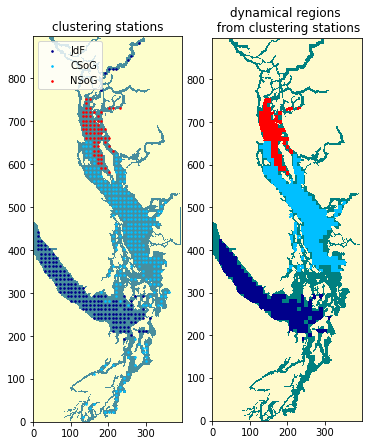

In [27]:
import matplotlib.colors as colors

fact = 1
fig = plt.figure(figsize=(9.1*fact, 7.09*fact))
ax = plt.subplot2grid((3,3), (0,1), colspan=1, rowspan=3)
#ax.text(0.04,.94,'f)', fontsize = 12, weight = 'bold', transform=ax.transAxes)
viz_tools.set_aspect(ax)    

cmap = colors.ListedColormap(['lemonchiffon','teal','chartreuse','deepskyblue','red','darkblue'])
boundaries = [0,1,2,3,4,5,6]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
w = plt.pcolormesh(regmask, cmap=cmap, norm=norm)
#plt.colorbar(w)
ax.set_title('dynamical regions \n from clustering stations')

ax = plt.subplot2grid((3,3), (0,0), colspan=1, rowspan=3)
ts = 10
mesh = ax.pcolormesh(tmask, vmin=0, vmax=2, cmap = cm.deep)
pts = ax.scatter(xs_jdf,ys_jdf,\
                 s=ts,c='darkblue',marker='.', label = 'JdF')
pts = ax.scatter(xs_csog,ys_csog,\
                 s=ts,c='deepskyblue',marker='.', label = 'CSoG')
pts = ax.scatter(xs_nsog,ys_nsog,\
                 s=ts,c='red',marker='.', label = 'NSoG')
ax.set_title('clustering stations')
plt.legend()

In [30]:
tcl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/BIO_clno_5_2015_reass.pkl'
xs_pkl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/Xcoords_for571_stations.pkl'
ys_pkl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/Ycoords_for571_stations.pkl'

cldes = pickle.load(open(tcl, 'rb'))
xs = pickle.load(open(xs_pkl, 'rb'))
ys = pickle.load(open(ys_pkl, 'rb'))

ys_csog = ys[cldes == 3]
xs_csog = xs[cldes == 3]

ys_nsog = ys[cldes == 4]
xs_nsog = xs[cldes == 4]

ys_jdf = ys[cldes == 5]
xs_jdf = xs[cldes == 5]

bath = '/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc'
grid = nc.Dataset(bath)
# print(grid)
# print(grid['gdept_1d'][0,26])
tmask = (grid['tmask'][0,0,:,:])
tmask
regmask = np.copy(tmask)
tmask_24 = (grid['tmask'][0,24,:,:])
regmask_24 = np.copy(tmask)
tmask_26 = (grid['tmask'][0,26,:,:])
regmask_26 = np.copy(tmask)

for i in range(0,len(ys_csog)):
    tx = xs_csog[i]
    ty = ys_csog[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 3
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 3
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 3
for i in range(0,len(ys_nsog)):
    tx = xs_nsog[i]
    ty = ys_nsog[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 4
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 4
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 4
for i in range(0,len(ys_jdf)):
    tx = xs_jdf[i]
    ty = ys_jdf[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 5
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 5
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 5

regmask[tmask==0] = 0
regmask_24[tmask_24==0] = 0
regmask_26[tmask_26==0] = 0

## adjust your regmask

xs = np.zeros([898,398])
ys = np.zeros([898,398])

for i in range(0,398):
    xs[:,i] = i
for j in range(0,898):
    ys[j,:] = j
    
regmask[(regmask == 5) & (ys > 700)] = 1
regmask[(regmask == 5) & (xs < 20)] = 1
regmask[(regmask == 3) & (ys < 225)] = 1
regmask[(regmask == 3) & (ys < 350) & (xs < 290)] = 1
regmask[(regmask == 3) & (ys < 350) & (xs > 290)] = 1
regmask[(regmask == 3) & (ys < 300) & (xs > 280) & (xs < 320)] = 1
# tmask[(regmask == 5) & (ys > 700)] = 1

regmask_3d = np.zeros([40,898,398])

for i in range(0,40):
    regmask_3d[i,:] = regmask

tmask = (grid['tmask'][0,:,:,:])
regmask_3d[tmask == 0] = 0
    

In [33]:
def extractor_masked(start, end, ftype, sdir, varname, fname,  treg, inletmask = False):

    '''USAGE:
    
    for a given variable in raw ncs of the PILA experiment 
    found in directory tree /data/tjarniko/results/BASERUN_EXP
    take by-layer means of the variable throughout the timeperiod specified

    start = '2015-01-01' #start of timeperiod
    end = '2015-12-31' #end of timeperiod (typically a year)
    ftype = 'carp' #type of model result .nc 
    sdir = 'MAIN/BR_3rd_2015' #where under directory tree do we find ncs 
    inletmask = True #are we masking out Toba/Bute/Jervis?
    varname = 'dissolved_inorganic_carbon' #name of variable
    fname = 'BR3_DIC_means' #name of resulting pkl 
    
    import extract_bylayer_mean as ebm
    ebm.extractor(start,end,ftype,sdir, inletmask, varname, fname)
    
    '''
    import matplotlib.pyplot as plt
    import netCDF4 as nc
    import numpy as np
    import scipy as sp
    import datetime as dt
    ""
    from salishsea_tools import (
        nc_tools,
        viz_tools,
        geo_tools,
        tidetools
    )
    import netCDF4 as nc
    import cmocean as cm
    import glob
    import arrow
    import gsw
    #import gef
    import pickle

    #where to store
    daily_means = np.zeros((40,365))
    ncfile_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    #no of days in array
    dayslen = len(arrow_array)
    
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_ncfile = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*/*_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        tnc_ncfile = glob.glob(nc_ncfile)
        #print(tnc_ncfile[0])
        ncfile_ar.append(tnc_ncfile[0])
        if i%50 == 0:
            print(i)

    print('done making nclen')

    for i in range(0,dayslen):

        if (i%50 ==0):
            print(ncfile_ar[i])
        t_test = nc.Dataset(ncfile_ar[i])
        
        tdat = t_test[varname][:]
        if i==0:
            print('shape of dataset is')
            print(np.shape(tdat))
        #remove border - 20 grid cells north and west

        tdat[:,:,878:898,:] = np.nan
        tdat[:,:,:,0:20] = np.nan
        #no zeros
        tdat[tdat == 0] = np.nan
        
        if (inletmask == True):
            #mask out inlets
            tdat[0,:,700:898,200:398] = np.nan
            tdat[0,:,550:700,255:398] = np.nan

        if (i==0):
            print('nansum(dataset) -checksum to make sure inlet mask works - false/true should give different answers')
            print(np.nansum(tdat))
            
        
        tdat_fc = tdat[0,:,:,:]
        tdat_fc[regmask_3d != treg] = np.nan
        tdat_alldomain = np.zeros([40])
        for q in range(0,40):
            tdat_alldomain[q] = np.nanmean(tdat_fc[q,:,:])

        daily_means[:,i] =  tdat_alldomain

    fname =  fname + '.pkl'
    pickle.dump(daily_means, open(fname, 'wb'))
    
    return

In [34]:
#constant
start = '2017-01-01' #start of timeperiod
end = '2017-12-31' #end of timeperiod (typically a year)
inletmask = False #are we masking out Toba/Bute/Jervis?
sdir = '/BUDGET' #where under directory tree do we find ncs 

# #changes
# shortdesc = 'BUDGET_DIC'
# ftype = 'carp' #type of model result .nc 
# varname = 'dissolved_inorganic_carbon' #name of variable
# fname = './pkls/' +shortdesc + '_means_inletsIN' #name of resulting pkl 
# extractor_blm(start, end, ftype, sdir, varname, fname,  inletmask)

#changes
shortdesc = 'BUDGET_DIC'
ftype = 'carp' #type of model result .nc 
varname = 'dissolved_inorganic_carbon' #name of variable
fname = './pkls/' +shortdesc + '_means_CSOG' #name of resulting pkl 
treg =3
extractor_masked(start, end, ftype, sdir, varname, fname,  treg, inletmask)
fname = './pkls/' +shortdesc + '_means_NSOG' #name of resulting pkl 
treg =4
extractor_masked(start, end, ftype, sdir, varname, fname,  treg, inletmask)
fname = './pkls/' +shortdesc + '_means_JDF' #name of resulting pkl 
treg =5
extractor_masked(start, end, ftype, sdir, varname, fname,  treg, inletmask)


0
50
100
150
200
250
300
350
done making nclen
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170101-20170101.nc
shape of dataset is
(1, 40, 898, 398)
nansum(dataset) -checksum to make sure inlet mask works - false/true should give different answers
4221499000.0


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice


/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170220-20170220.nc
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170411-20170411.nc
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170531-20170531.nc
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170720-20170720.nc
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170908-20170908.nc
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171028-20171028.nc
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171217-20171217.nc
0
50
100
150
200
250
300
350
done making nclen
/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_201701

In [4]:
#extract means for BR1-BR3, get fraser discharge
#var
BR1_var = pickle.load(open('../pkls/BR1_DIC_means_inletsIN.pkl' , 'rb')) 
BR2_var = pickle.load(open('../pkls/BR2_DIC_means_inletsIN.pkl' , 'rb')) 
BR3_var = pickle.load(open('../pkls/BR3_DIC_means_inletsIN.pkl' , 'rb')) 

PI1_var = pickle.load(open('../pkls/PI1_DIC_means_inletsIN.pkl' , 'rb')) 
PI2_var = pickle.load(open('../pkls/PI2_DIC_means_inletsIN.pkl' , 'rb')) 
PI3rr_var = pickle.load(open('../pkls/PI3rr_DIC_means_inletsIN.pkl' , 'rb')) 
PI4_var = pickle.load(open('../pkls/PI4_DIC_means_inletsIN.pkl' , 'rb')) 
PI4_var[PI4_var == 0] = np.nan
PI9_var = pickle.load(open('../pkls/PI9_DIC_means_inletsIN.pkl' , 'rb')) 
PI9_var[PI9_var == 0] = np.nan
Fraser_discharge = pickle.load(open('../pkls/Fraser_2015_year_runoff_m3_s.pkl', 'rb'))  



mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
bath = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
depth = mesh['gdept_1d'][:]
days_in = np.arange(1,366,1)
#make a long 3-year dataset to be able to compare spinup progress for BR run
 
BR3_var_jdf = pickle.load(open('../pkls/BR3_DIC_means_jdf_BOX.pkl','rb'))
PI9_var_jdf = pickle.load(open('../pkls/PI9_DIC_means_jdf_BOX.pkl','rb'))
BR3_var_cs = pickle.load(open('../pkls/BR3_DIC_means_cs_BOX.pkl','rb'))
PI9_var_cs = pickle.load(open('../pkls/PI9_DIC_means_cs_BOX.pkl','rb'))
BR3_var_ns = pickle.load(open('../pkls/BR3_DIC_means_ns_BOX.pkl','rb'))
PI9_var_ns = pickle.load(open('../pkls/PI9_DIC_means_ns_BOX.pkl','rb'))
BR3_var_haro = pickle.load(open('../pkls/BR3_DIC_means_haro_BOX.pkl','rb'))
PI9_var_haro = pickle.load(open('../pkls/PI9_DIC_means_haro_BOX.pkl','rb'))

BR3_var_jdf2 = pickle.load(open('../pkls/BR3_DIC_means_jdf2_BOX.pkl','rb'))
PI9_var_jdf2 = pickle.load(open('../pkls/PI9_DIC_means_jdf2_BOX.pkl','rb'))
BR3_var_cs2 = pickle.load(open('../pkls/BR3_DIC_means_cs2_BOX.pkl','rb'))
PI9_var_cs2 = pickle.load(open('../pkls/PI9_DIC_means_cs2_BOX.pkl','rb'))
BR3_var_ns2 = pickle.load(open('../pkls/BR3_DIC_means_ns2_BOX.pkl','rb'))
PI9_var_ns2 = pickle.load(open('../pkls/PI9_DIC_means_ns2_BOX.pkl','rb'))
BR3_var_haro2 = pickle.load(open('../pkls/BR3_DIC_means_haro2_BOX.pkl','rb'))
PI9_var_haro2 = pickle.load(open('../pkls/PI9_DIC_means_haro2_BOX.pkl','rb'))

BR3_var_jdf3 = pickle.load(open('../pkls/BR3_DIC_means_jdf3_BOX.pkl','rb'))
PI9_var_jdf3 = pickle.load(open('../pkls/PI9_DIC_means_jdf3_BOX.pkl','rb'))
BR3_var_cs3 = pickle.load(open('../pkls/BR3_DIC_means_cs3_BOX.pkl','rb'))
PI9_var_cs3 = pickle.load(open('../pkls/PI9_DIC_means_cs3_BOX.pkl','rb'))
BR3_var_ns3 = pickle.load(open('../pkls/BR3_DIC_means_ns3_BOX.pkl','rb'))
PI9_var_ns3 = pickle.load(open('../pkls/PI9_DIC_means_ns3_BOX.pkl','rb'))
BR3_var_haro3 = pickle.load(open('../pkls/BR3_DIC_means_haro3_BOX.pkl','rb'))
PI9_var_haro3 = pickle.load(open('../pkls/PI9_DIC_means_haro3_BOX.pkl','rb'))

BR3_dp = np.nanmean(BR3_var, axis =1)
PI9_dp = np.nanmean(PI9_var, axis =1)

BR3_jdf_dp = np.nanmean(BR3_var_jdf, axis =1)
PI9_jdf_dp = np.nanmean(PI9_var_jdf, axis =1)
BR3_cs_dp = np.nanmean(BR3_var_cs, axis =1)
PI9_cs_dp = np.nanmean(PI9_var_cs, axis =1)
BR3_ns_dp = np.nanmean(BR3_var_ns, axis =1)
PI9_ns_dp = np.nanmean(PI9_var_ns, axis =1)
BR3_haro_dp = np.nanmean(BR3_var_haro, axis =1)
PI9_haro_dp = np.nanmean(PI9_var_haro, axis =1)

BR3_jdf2_dp = np.nanmean(BR3_var_jdf2, axis =1)
PI9_jdf2_dp = np.nanmean(PI9_var_jdf2, axis =1)
BR3_cs2_dp = np.nanmean(BR3_var_cs2, axis =1)
PI9_cs2_dp = np.nanmean(PI9_var_cs2, axis =1)
BR3_ns2_dp = np.nanmean(BR3_var_ns2, axis =1)
PI9_ns2_dp = np.nanmean(PI9_var_ns2, axis =1)
BR3_haro2_dp = np.nanmean(BR3_var_haro2, axis =1)
PI9_haro2_dp = np.nanmean(PI9_var_haro2, axis =1)

BR3_jdf3_dp = np.nanmean(BR3_var_jdf3, axis =1)
PI9_jdf3_dp = np.nanmean(PI9_var_jdf3, axis =1)
BR3_cs3_dp = np.nanmean(BR3_var_cs3, axis =1)
PI9_cs3_dp = np.nanmean(PI9_var_cs3, axis =1)
BR3_ns3_dp = np.nanmean(BR3_var_ns3, axis =1)
PI9_ns3_dp = np.nanmean(PI9_var_ns3, axis =1)
BR3_haro3_dp = np.nanmean(BR3_var_haro3, axis =1)
PI9_haro3_dp = np.nanmean(PI9_var_haro3, axis =1)

depths = mesh['gdept_1d'][:]
zdepth = depths[0]   

jdf_x = 85; jdf_y = 325; jdf_col = 'teal'
jdf2_x = 50; jdf2_y = 370; jdf2_col = 'mediumaquamarine'
jdf3_x = 130; jdf3_y = 290; jdf3_col = 'lightseagreen'

cs_x = 250; cs_y = 500; cs_col = 'royalblue'
cs2_x = 280; cs2_y = 440; cs2_col = 'navy'
cs3_x = 220; cs3_y = 540; cs3_col = 'dodgerblue'

haro_x = 230; haro_y = 310; haro_col = 'tomato'
haro2_x = 340; haro2_y = 290; haro2_col = 'firebrick'
haro3_x = 260; haro3_y = 335; haro3_col = 'indianred'


ns_x = 160; ns_y = 680; ns_col = 'olive'
ns2_x = 150; ns2_y = 640; ns2_col = 'yellowgreen'
ns3_x = 155; ns3_y = 710; ns3_col = 'palegoldenrod'


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: R

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


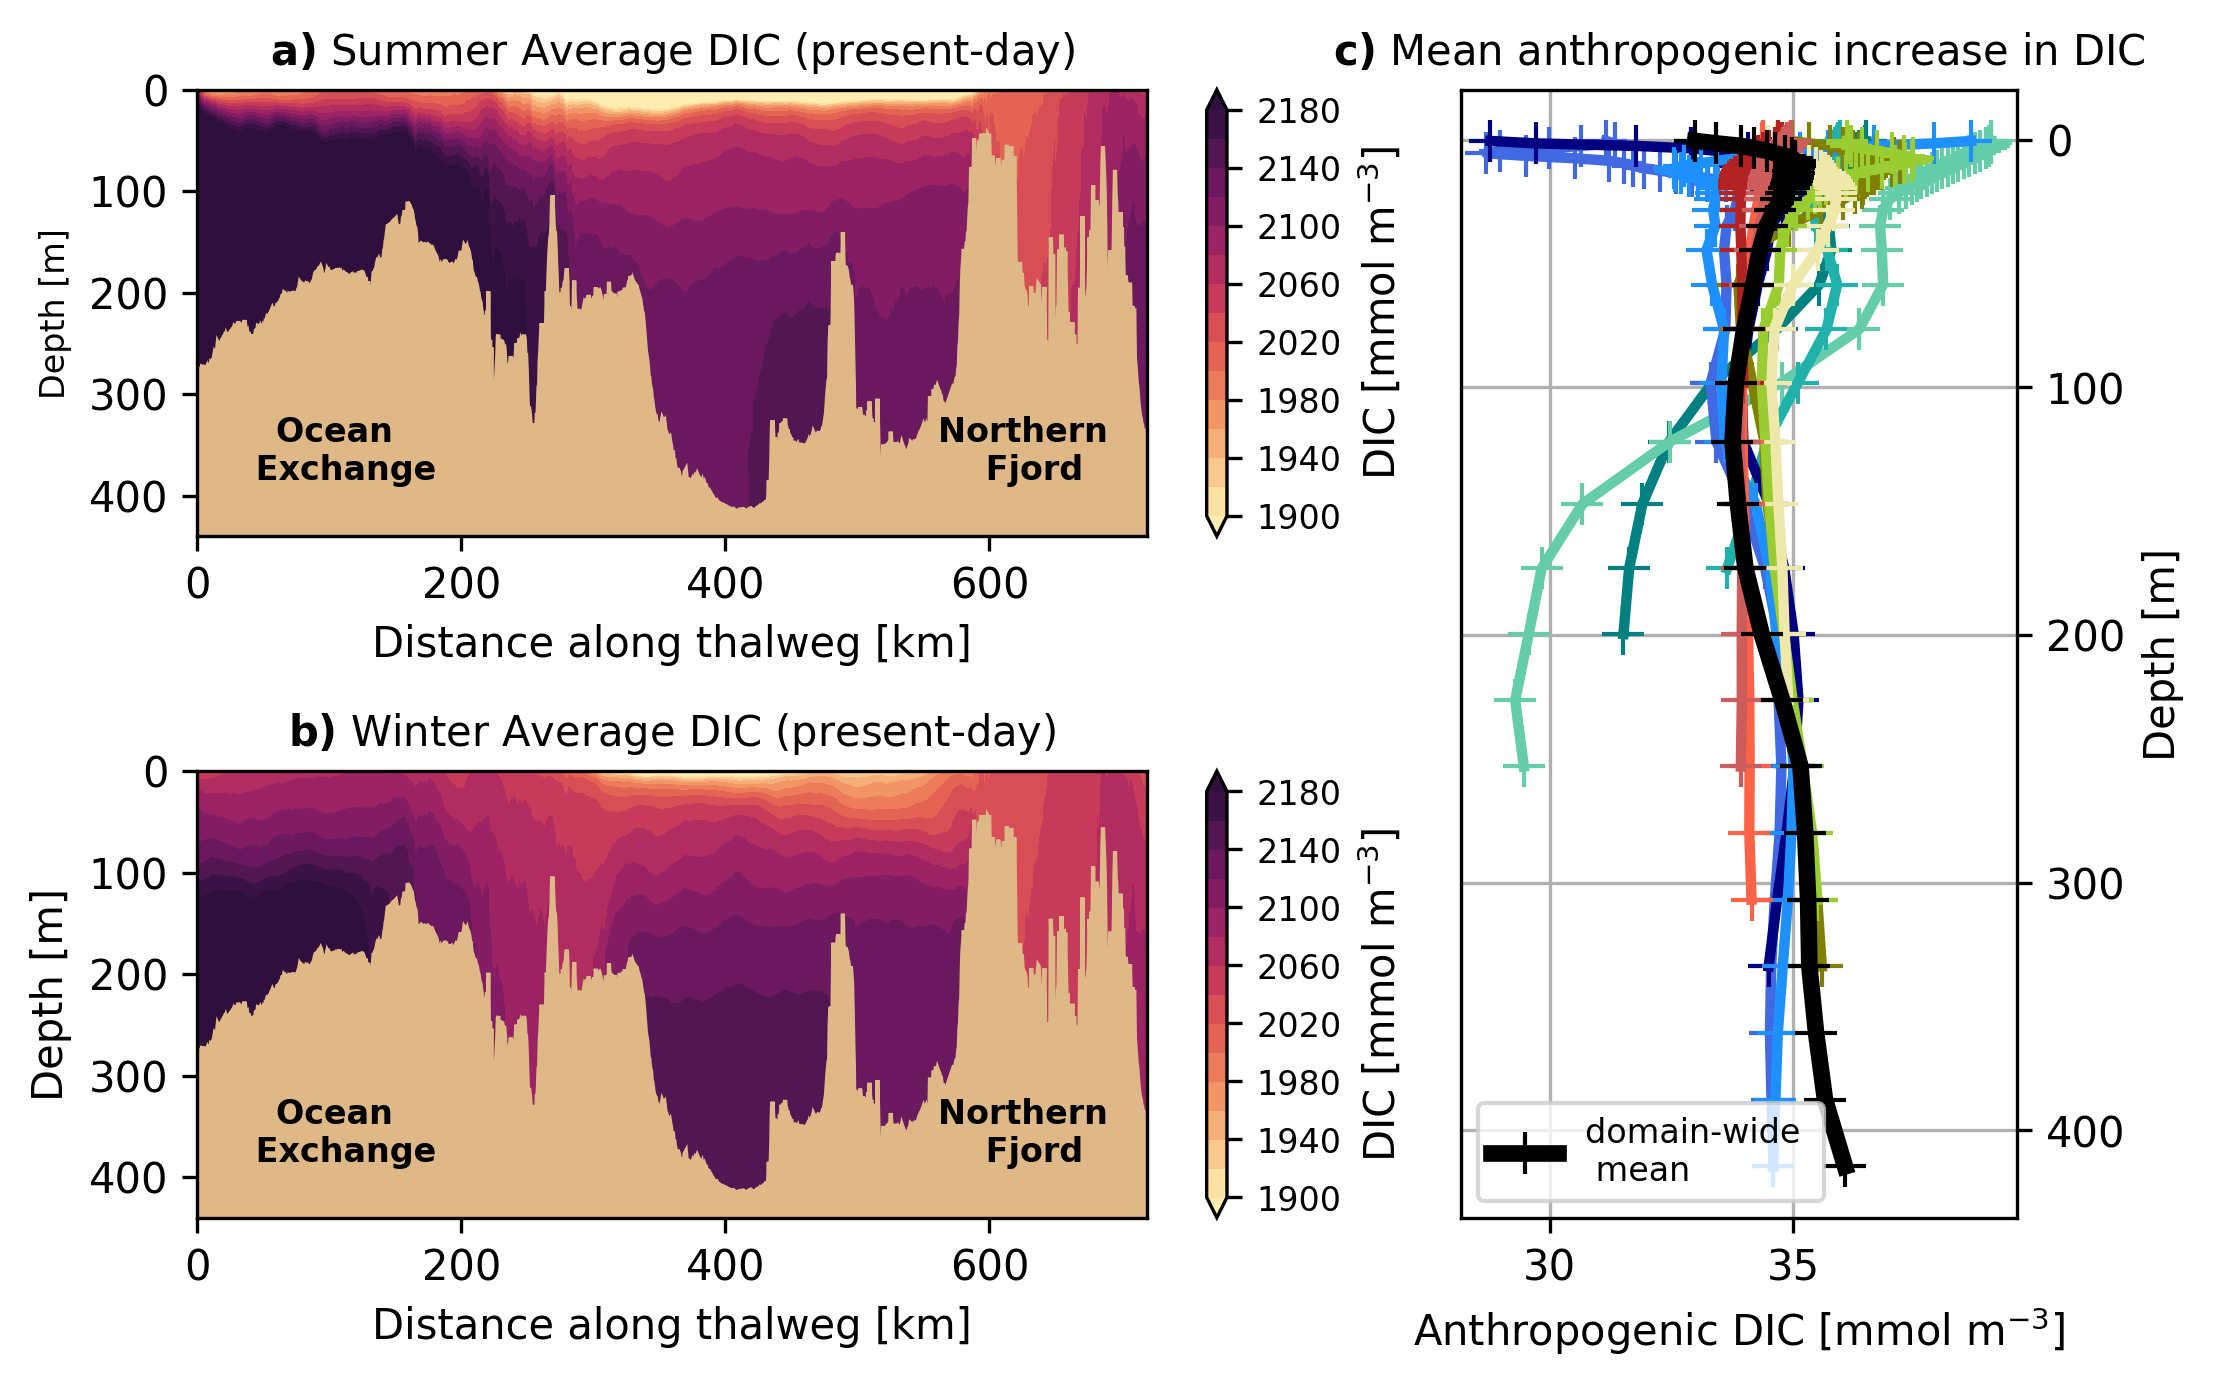

In [5]:
tmesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
fact = 1/72; fs = 10
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

#plt.rcParams["font.family"] = "cursive"
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

fig = plt.figure(figsize=(19/2.54, 12/2.54),dpi = 300)

ax3 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_summer, bathy, meshmask,\
                    np.arange(1900, 2200, 20), cmap = cm.matter)
ax3.set_title(r'$\bf{a)}$ Summer Average DIC (present-day)',fontsize = fs)
ax3.set_xlabel('Distance along thalweg [km]',fontsize = fs)
ax3.set_ylabel('Depth [m]',fontsize = 8)
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('DIC [mmol m$^{-3}$]', fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
#ax3.text(0.03, 0.03, 'd)', transform=ax3.transAxes, fontsize=8, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.text(0.15, 0.11, 'Ocean \n Exchange', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.text(0.875, 0.11, 'Northern \n Fjord', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.set_ylim([0,440])
ax3.invert_yaxis()

#
ax3 = plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_winter, bathy, meshmask,\
                    np.arange(1900, 2200, 20), cmap = cm.matter)
ax3.set_title(r'$\bf{b)}$ Winter Average DIC (present-day)',fontsize = fs)
ax3.set_xlabel('Distance along thalweg [km]',fontsize = fs)
ax3.set_ylabel('Depth [m]',fontsize = fs)
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('DIC [mmol m$^{-3}$]', fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
#ax3.text(0.03, 0.03, 'd)', transform=ax3.transAxes, fontsize=8, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.text(0.15, 0.11, 'Ocean \n Exchange', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.text(0.875, 0.11, 'Northern \n Fjord', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.set_ylim([0,440])
ax3.invert_yaxis()



# depth profile
ax3 = plt.subplot2grid((2,3), (0,2), colspan=1, rowspan=2) 

ax3.plot(BR3_jdf_dp-PI9_jdf_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = jdf_col, markersize = 10)# label = 'JdF mean')
ax3.plot(BR3_jdf2_dp-PI9_jdf2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = jdf2_col, markersize = 10)# label = 'JdF mean')
ax3.plot(BR3_jdf3_dp-PI9_jdf3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = jdf3_col, markersize = 10)# label = 'JdF mean')

ax3.plot(BR3_cs_dp-PI9_cs_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = cs_col, markersize = 10)# label = 'cs mean')
ax3.plot(BR3_cs2_dp-PI9_cs2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = cs2_col, markersize = 10)# label = 'cs mean')
ax3.plot(BR3_cs3_dp-PI9_cs3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = cs3_col, markersize = 10)# label = 'cs mean')

ax3.plot(BR3_ns_dp-PI9_ns_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = ns_col, markersize = 10)# label = 'ns mean')
ax3.plot(BR3_ns2_dp-PI9_ns2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = ns2_col, markersize = 10)# label = 'ns mean')
ax3.plot(BR3_ns3_dp-PI9_ns3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = ns3_col, markersize = 10)# label = 'ns mean')

ax3.plot(BR3_haro_dp-PI9_haro_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = haro_col, markersize = 10)# label = 'haro mean')
ax3.plot(BR3_haro2_dp-PI9_haro2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = haro2_col, markersize = 10)# label = 'haro mean')
ax3.plot(BR3_haro3_dp-PI9_haro3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = haro3_col, markersize = 10)# label = 'haro mean')

ax3.plot(BR3_dp-PI9_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 4, color = 'k',\
         markersize = 10, label = 'domain-wide \n mean')

ax3.set_title(r'$\bf{c)}$ Mean anthropogenic increase in DIC', fontsize = fs)
ax3.invert_yaxis()
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.legend(loc = 'lower left', fontsize = fs-2)
ax3.set_xlabel('Anthropogenic DIC [mmol m$^{-3}$]', fontsize = fs)
ax3.set_ylabel('Depth [m]', fontsize = fs)
ax3.grid()
plt.tight_layout()

fig.savefig('./CG_FIGS/FIG_CG_03_mean_and_extra.jpg')
# 

In [6]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
# bathy, lons, lats = tidetools.get_bathy_data(grid_B)
# print(mesh_mask)
lons = grid_B['nav_lon'][:]
lats = grid_B['nav_lat'][:]
bathy2 = grid_B['Bathymetry'][:]
tmask = mesh_mask.variables['tmask'][:]

gdept = mesh_mask.variables['gdept_0'][0,:,:,:]
gdepw = mesh_mask.variables['gdepw_0'][0,:,:,:]

e3t = mesh_mask.variables['e3t_0'][0,:,:,:]
e3w = mesh_mask.variables['e3w_0'][0,:,:,:]

def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.
    Reference: http://www.movable-type.co.uk/scripts/latlong.html
    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`
    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`
    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`
    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`
    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance_along_curve(lons, lats):
    """Calculate cumulative distance between points in lons, lats
    :arg lons: longitude points
    :type lons: numpy array
    :arg lats: latitude points
    :type lats: numpy array
    :returns: dist, a numpy array with distance along track
    """
    dist = [0]
    for i in np.arange(1, lons.shape[0]):
        newdist = dist[i-1] + haversine(lons[i], lats[i],
                                                  lons[i-1], lats[i-1])
        dist.append(newdist)
    dist = np.array(dist)
    return dist


def load_thalweg(
    gdept, lons, lats,
    filename='/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt'
):
    """Thalweg grid indices, depths and disatance.
    :arg gdept: full model depth array (shape 40x898x398)
    :type gdept: numpy array
    :arg lons: model longitude array (shape 898x398)
    :type lons: numpy array
    :arg lats: model latitude array (shape 898x398)
    :type lats: numpy array
    :returns: tpoints, gdept_thal, xx_thal
    An array of thalweg grid indices, depths and distance.
    """
    tpoints = np.loadtxt(filename, delimiter=' ', dtype=int)
    gdept_thal = gdept[:, tpoints[:, 0], tpoints[:, 1]]
    lons_thal = lons[tpoints[:, 0], tpoints[:, 1]]
    lats_thal = lats[tpoints[:, 0], tpoints[:, 1]]
    xx_thal = distance_along_curve(lons_thal, lats_thal)
    xx_thal = xx_thal + np.zeros(gdept_thal.shape)
    return tpoints, gdept_thal, xx_thal


thalweg_points, gdept_thal, xx = load_thalweg(gdept, lons, lats)

In [7]:
jdf_x = 85; jdf_y = 325; jdf_col = 'teal'
jdf2_x = 50; jdf2_y = 370; jdf2_col = 'mediumaquamarine'  ###
jdf3_x = 130; jdf3_y = 290; jdf3_col = 'lightseagreen'

cs_x = 250; cs_y = 500; cs_col = 'royalblue'
cs2_x = 280; cs2_y = 440; cs2_col = 'navy'
cs3_x = 220; cs3_y = 540; cs3_col = 'dodgerblue'

haro_x = 230; haro_y = 310; haro_col = 'tomato'
haro2_x = 340; haro2_y = 290; haro2_col = 'firebrick'
haro3_x = 260; haro3_y = 335; haro3_col = 'indianred'


ns_x = 160; ns_y = 680; ns_col = 'olive'
ns2_x = 150; ns2_y = 640; ns2_col = 'yellowgreen'
ns3_x = 155; ns3_y = 710; ns3_col = 'palegoldenrod'


# print(thalweg_points[70:110,:])
# print(thalweg_points[77,:])

t_x = jdf_x; t_y = jdf_y

xs = thalweg_points[:,1]
ys = thalweg_points[:,0]

st_xs = np.array([jdf_x, jdf2_x, jdf3_x, haro_x, haro2_x, haro3_x, ns_x, ns2_x, ns3_x, cs_x, cs2_x, cs3_x])
st_ys = np.array([jdf_y, jdf2_y, jdf3_y, haro_y, haro2_y, haro3_y, ns_y, ns2_y, ns3_y, cs_y, cs2_y, cs3_y])
cols = [jdf_col, jdf2_col, jdf3_col, haro_col, haro2_col, haro3_col, ns_col, ns2_col, ns3_col, cs_col, cs2_col, cs3_col]
tpoints = np.zeros_like(st_xs)

for i in range(0,len(st_xs)):
    t_x = st_xs[i]
    t_y = st_ys[i]
    squared_dist = (xs-t_x)**2 + (ys-t_y)**2
#    print(np.nanmin(squared_dist))
    w = np.where(squared_dist == np.nanmin(squared_dist))
#     print(thalweg_points[w,:])
#     print(f'{t_x},{t_y}')
    tdist = xx[0,w]
    print(tdist[0,0])
    print(type(tdist))
    print(np.shape(tdist))
    print(np.shape(tdist[0,0]))
    tpoints[i] = tdist[0,0]

print(tpoints)
#print(xx[:,1])

78.50180302286462
<class 'numpy.ndarray'>
(1, 1)
()
38.62736688753894
<class 'numpy.ndarray'>
(1, 1)
()
117.33268114914623
<class 'numpy.ndarray'>
(1, 1)
()
231.464727622876
<class 'numpy.ndarray'>
(1, 1)
()
282.9736157088144
<class 'numpy.ndarray'>
(1, 1)
()
261.5752915846608
<class 'numpy.ndarray'>
(1, 1)
()
549.9475471741787
<class 'numpy.ndarray'>
(1, 1)
()
528.983492775422
<class 'numpy.ndarray'>
(1, 1)
()
571.1826148346049
<class 'numpy.ndarray'>
(1, 1)
()
396.9102568491354
<class 'numpy.ndarray'>
(1, 1)
()
357.87804641933525
<class 'numpy.ndarray'>
(1, 1)
()
432.8308059498386
<class 'numpy.ndarray'>
(1, 1)
()
[ 78  38 117 231 282 261 549 528 571 396 357 432]


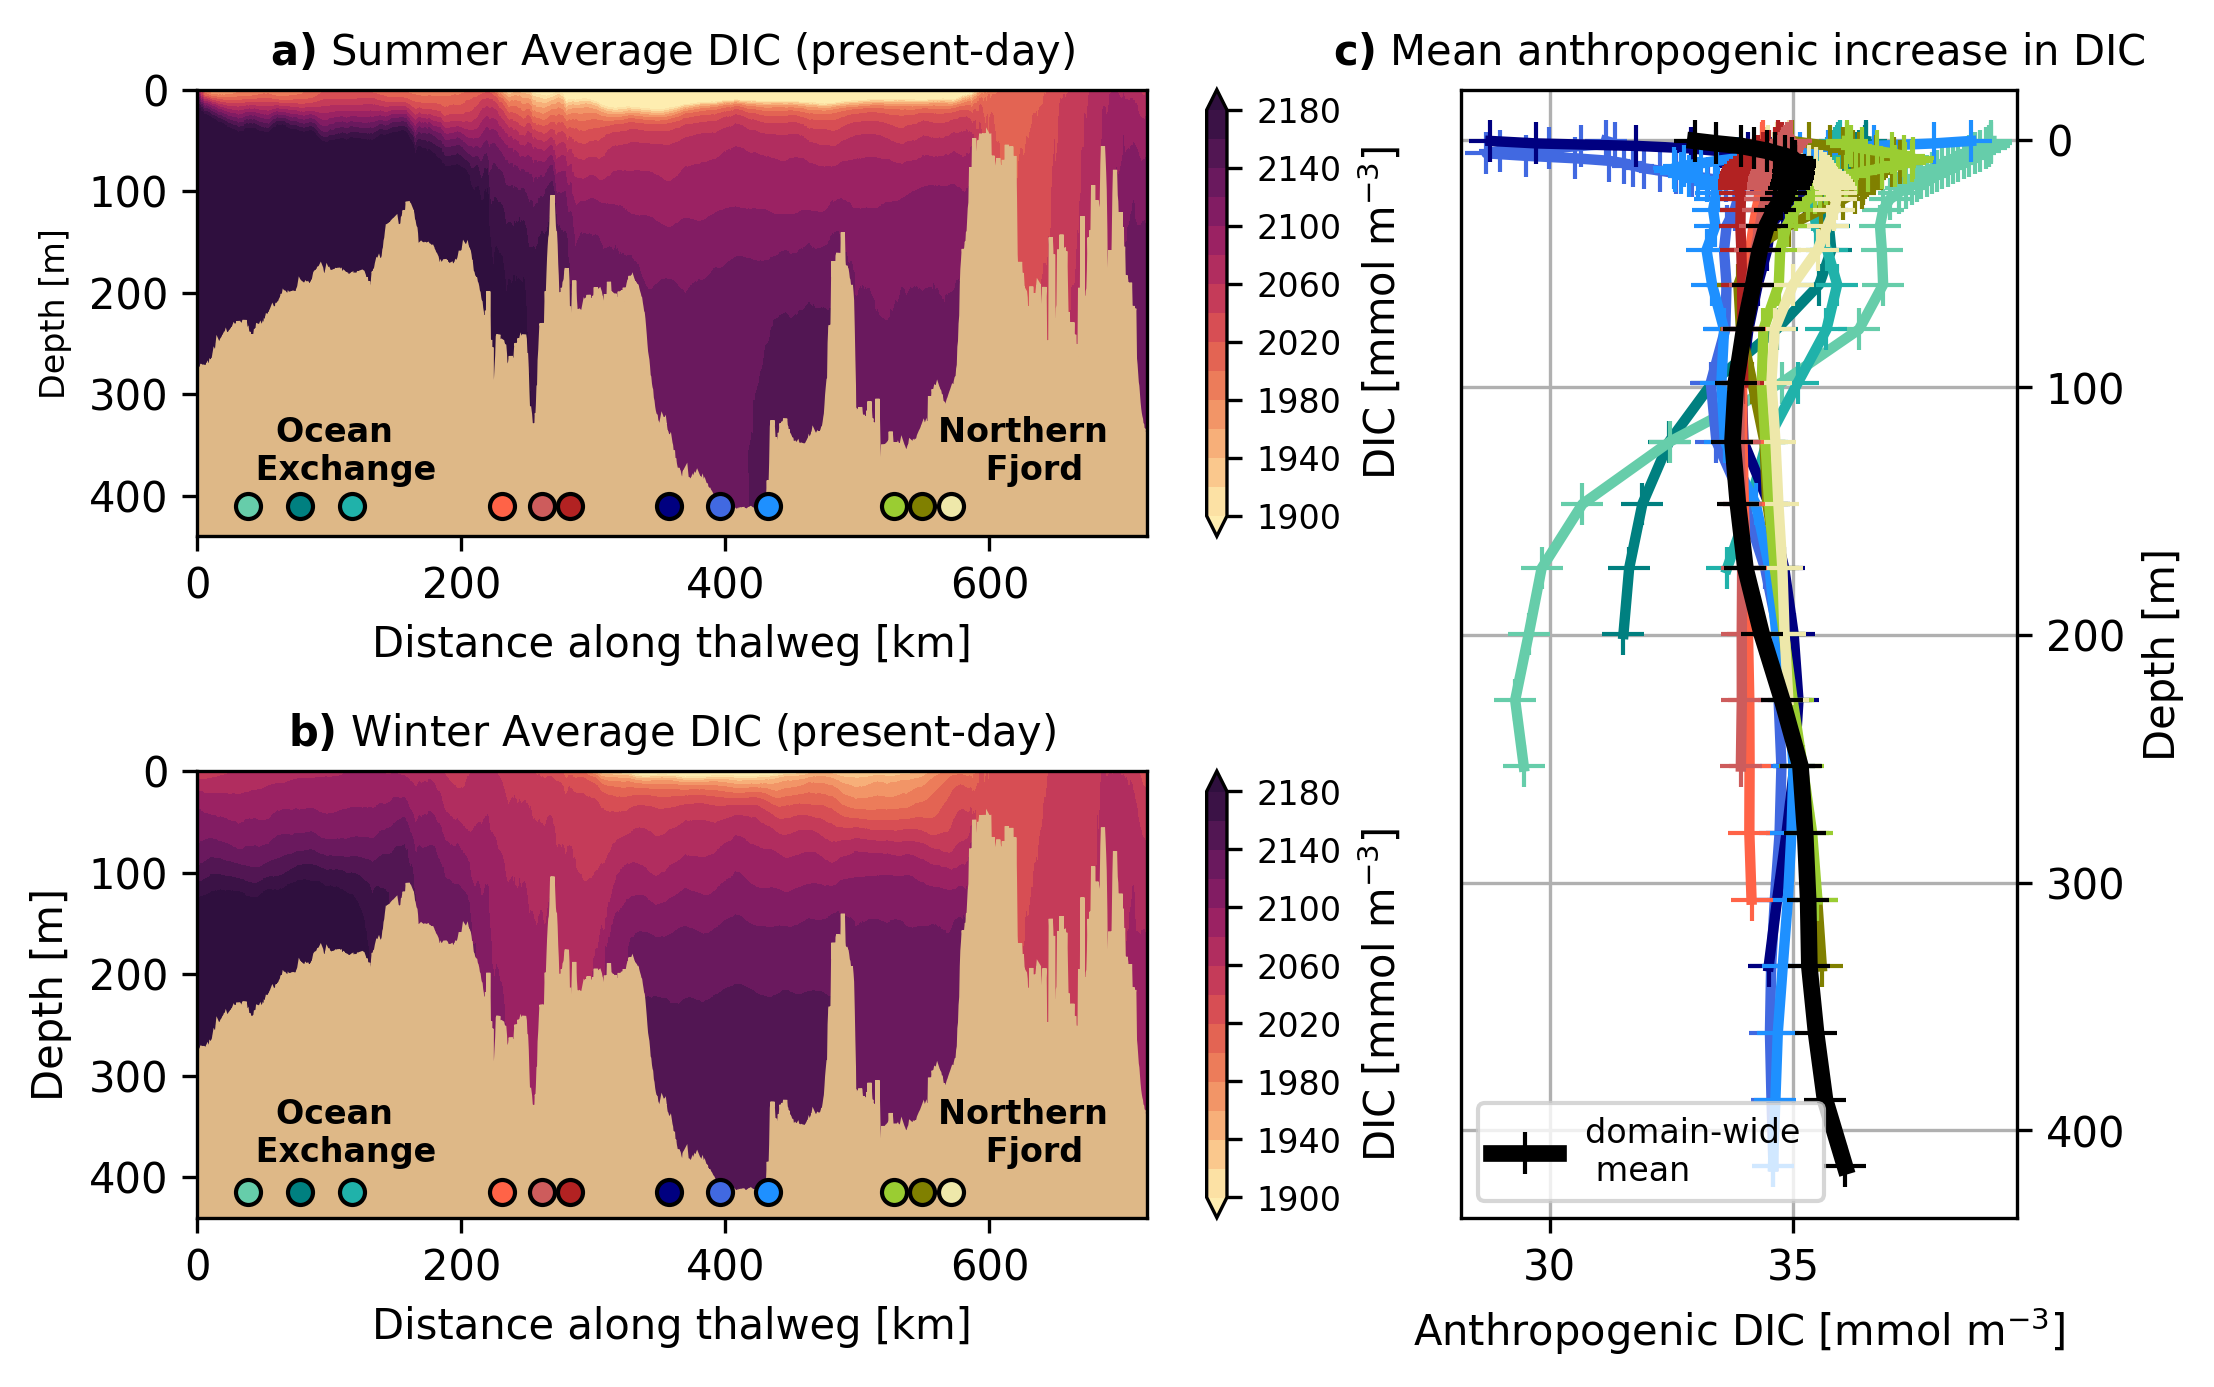

In [23]:
tmesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
fact = 1/72; fs = 10
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

#plt.rcParams["font.family"] = "cursive"
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

fig = plt.figure(figsize=(19/2.54, 12/2.54),dpi = 300)

ax3 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_summer, bathy, meshmask,\
                    np.arange(1900, 2200, 20), cmap = cm.matter)

for i in range(0,len(st_xs)):
    ax3.scatter(tpoints[i],410, color = cols[i], edgecolors = 'k', zorder = 10)
ax3.set_title(r'$\bf{a)}$ Summer Average DIC (present-day)',fontsize = fs)
ax3.set_xlabel('Distance along thalweg [km]',fontsize = fs)
ax3.set_ylabel('Depth [m]',fontsize = 8)
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('DIC [mmol m$^{-3}$]', fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
#ax3.text(0.03, 0.03, 'd)', transform=ax3.transAxes, fontsize=8, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.text(0.15, 0.11, 'Ocean \n Exchange', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.text(0.875, 0.11, 'Northern \n Fjord', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.set_ylim([0,440])
ax3.invert_yaxis()

#
ax3 = plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_winter, bathy, meshmask,\
                    np.arange(1900, 2200, 20), cmap = cm.matter)
for i in range(0,len(st_xs)):
    ax3.scatter(tpoints[i],415, color = cols[i], edgecolors = 'k', zorder = 10)
ax3.set_title(r'$\bf{b)}$ Winter Average DIC (present-day)',fontsize = fs)
ax3.set_xlabel('Distance along thalweg [km]',fontsize = fs)
ax3.set_ylabel('Depth [m]',fontsize = fs)
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('DIC [mmol m$^{-3}$]', fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
#ax3.text(0.03, 0.03, 'd)', transform=ax3.transAxes, fontsize=8, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.text(0.15, 0.11, 'Ocean \n Exchange', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.text(0.875, 0.11, 'Northern \n Fjord', transform=ax3.transAxes, \
         fontsize=8, fontweight='bold', ha ='center', va='bottom')
ax3.set_ylim([0,440])
ax3.invert_yaxis()



# depth profile
ax3 = plt.subplot2grid((2,3), (0,2), colspan=1, rowspan=2) 

ax3.plot(BR3_jdf_dp-PI9_jdf_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = jdf_col, markersize = 10)# label = 'JdF mean')
ax3.plot(BR3_jdf2_dp-PI9_jdf2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = jdf2_col, markersize = 10)# label = 'JdF mean')
ax3.plot(BR3_jdf3_dp-PI9_jdf3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = jdf3_col, markersize = 10)# label = 'JdF mean')

ax3.plot(BR3_cs_dp-PI9_cs_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = cs_col, markersize = 10)# label = 'cs mean')
ax3.plot(BR3_cs2_dp-PI9_cs2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = cs2_col, markersize = 10)# label = 'cs mean')
ax3.plot(BR3_cs3_dp-PI9_cs3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = cs3_col, markersize = 10)# label = 'cs mean')

ax3.plot(BR3_ns_dp-PI9_ns_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = ns_col, markersize = 10)# label = 'ns mean')
ax3.plot(BR3_ns2_dp-PI9_ns2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = ns2_col, markersize = 10)# label = 'ns mean')
ax3.plot(BR3_ns3_dp-PI9_ns3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = ns3_col, markersize = 10)# label = 'ns mean')

ax3.plot(BR3_haro_dp-PI9_haro_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = haro_col, markersize = 10)# label = 'haro mean')
ax3.plot(BR3_haro2_dp-PI9_haro2_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = haro2_col, markersize = 10)# label = 'haro mean')
ax3.plot(BR3_haro3_dp-PI9_haro3_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 2.5, color = haro3_col, markersize = 10)# label = 'haro mean')

ax3.plot(BR3_dp-PI9_dp,zdepth, marker = '+', \
         linestyle = '-', linewidth = 4, color = 'k',\
         markersize = 10, label = 'domain-wide \n mean')

ax3.set_title(r'$\bf{c)}$ Mean anthropogenic increase in DIC', fontsize = fs)
ax3.invert_yaxis()
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.legend(loc = 'lower left', fontsize = fs-2)
ax3.set_xlabel('Anthropogenic DIC [mmol m$^{-3}$]', fontsize = fs)
ax3.set_ylabel('Depth [m]', fontsize = fs)
ax3.grid()
plt.tight_layout()

fig.savefig('./CG_FIGS/FIG_CG_03_mean_and_extra.jpg')
# 

In [9]:
print('jdf')
print(f'{np.nanmax(BR3_jdf_dp-PI9_jdf_dp)},{np.nanmin(BR3_jdf_dp-PI9_jdf_dp)}')
print(f'{np.nanmax(BR3_jdf2_dp-PI9_jdf2_dp)},{np.nanmin(BR3_jdf2_dp-PI9_jdf2_dp)}')
print(f'{np.nanmax(BR3_jdf3_dp-PI9_jdf3_dp)},{np.nanmin(BR3_jdf3_dp-PI9_jdf3_dp)}')

##
print('haro')
print(f'{np.nanmax(BR3_haro_dp-PI9_haro_dp)},{np.nanmin(BR3_haro_dp-PI9_haro_dp)}')
print(f'{np.nanmax(BR3_haro2_dp-PI9_haro2_dp)},{np.nanmin(BR3_haro2_dp-PI9_haro2_dp)}')
print(f'{np.nanmax(BR3_haro3_dp-PI9_haro3_dp)},{np.nanmin(BR3_haro3_dp-PI9_haro3_dp)}')
print('cs')
print(f'{np.nanmax(BR3_cs_dp-PI9_cs_dp)},{np.nanmin(BR3_cs_dp-PI9_cs_dp)}')
print(f'{np.nanmax(BR3_cs2_dp-PI9_cs2_dp)},{np.nanmin(BR3_cs2_dp-PI9_cs2_dp)}')
print(f'{np.nanmax(BR3_cs3_dp-PI9_cs3_dp)},{np.nanmin(BR3_cs3_dp-PI9_cs3_dp)}')
print('ns')
print(f'{np.nanmax(BR3_ns_dp-PI9_ns_dp)},{np.nanmin(BR3_ns_dp-PI9_ns_dp)}')
print(f'{np.nanmax(BR3_ns2_dp-PI9_ns2_dp)},{np.nanmin(BR3_ns2_dp-PI9_ns2_dp)}')
print(f'{np.nanmax(BR3_ns3_dp-PI9_ns3_dp)},{np.nanmin(BR3_ns3_dp-PI9_ns3_dp)}')



# ax3.plot(BR3_jdf_dp-PI9_jdf_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = jdf_col, markersize = 10)# label = 'JdF mean')
# ax3.plot(BR3_jdf2_dp-PI9_jdf2_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = jdf2_col, markersize = 10)# label = 'JdF mean')
# ax3.plot(BR3_jdf3_dp-PI9_jdf3_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = jdf3_col, markersize = 10)# label = 'JdF mean')

# ax3.plot(BR3_cs_dp-PI9_cs_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = cs_col, markersize = 10)# label = 'cs mean')
# ax3.plot(BR3_cs2_dp-PI9_cs2_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = cs2_col, markersize = 10)# label = 'cs mean')
# ax3.plot(BR3_cs3_dp-PI9_cs3_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = cs3_col, markersize = 10)# label = 'cs mean')

# ax3.plot(BR3_ns_dp-PI9_ns_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = ns_col, markersize = 10)# label = 'ns mean')
# ax3.plot(BR3_ns2_dp-PI9_ns2_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = ns2_col, markersize = 10)# label = 'ns mean')
# ax3.plot(BR3_ns3_dp-PI9_ns3_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = ns3_col, markersize = 10)# label = 'ns mean')

# ax3.plot(BR3_haro_dp-PI9_haro_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = haro_col, markersize = 10)# label = 'haro mean')
# ax3.plot(BR3_haro2_dp-PI9_haro2_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = haro2_col, markersize = 10)# label = 'haro mean')
# ax3.plot(BR3_haro3_dp-PI9_haro3_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 2.5, color = haro3_col, markersize = 10)# label = 'haro mean')

# ax3.plot(BR3_dp-PI9_dp,zdepth, marker = '+', \
#          linestyle = '-', linewidth = 4, color = 'k',\
#          markersize = 10, label = 'domain-wide \n mean')


jdf
36.487766213612986,31.514142096532396
39.06236655875409,29.293297838185026
35.959906423908706,33.63894879066811
haro
34.396263645119916,33.94625963184944
34.760776969178096,33.88281015892562
34.95880745665659,33.88772240207618
cs
34.755089495933134,28.703696222174585
35.23227806613886,28.786563570205544
38.64651882223893,32.546268661708154
ns
37.18881668717904,33.872134190389716
37.45464970836906,34.35204977793228
35.87998381314219,34.460594365368024


## calculate full year mean for DIC and TA, 

In [10]:

# start ='2015-01-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_dic


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/BR3_DIC_fullyear_mean.pkl", 'wb'))

In [11]:

# start ='2015-01-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['total_alkalinity'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_dic


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/BR3_TA_fullyear_mean.pkl", 'wb'))

In [12]:

# start ='2015-01-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI9/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_dic


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/PI9_DIC_fullyear_mean.pkl", 'wb'))

In [13]:

# start ='2015-01-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI9/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_TA = tn['total_alkalinity'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_TA


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/PI9_TA_fullyear_mean.pkl", 'wb'))

## make SF by-layer and fraser-phyto

In [14]:
# #extract means for BR1-BR3, get fraser discharge
# #var
# BR1_var = pickle.load(open('../pkls/BR1_DIC_means_inletsIN.pkl' , 'rb')) 
# BR2_var = pickle.load(open('../pkls/BR2_DIC_means_inletsIN.pkl' , 'rb')) 
# BR3_var = pickle.load(open('../pkls/BR3_DIC_means_inletsIN.pkl' , 'rb')) 

# PI1_var = pickle.load(open('../pkls/PI1_DIC_means_inletsIN.pkl' , 'rb')) 
# PI2_var = pickle.load(open('../pkls/PI2_DIC_means_inletsIN.pkl' , 'rb')) 
# PI3rr_var = pickle.load(open('../pkls/PI3rr_DIC_means_inletsIN.pkl' , 'rb')) 
# PI4_var = pickle.load(open('../pkls/PI4_DIC_means_inletsIN.pkl' , 'rb')) 
# PI4_var[PI4_var == 0] = np.nan
# PI5_var = pickle.load(open('../pkls/PI5_DIC_means_inletsIN.pkl' , 'rb')) 
# PI5_var[PI5_var == 0] = np.nan
# Fraser_discharge = pickle.load(open('../pkls/Fraser_2015_year_runoff_m3_s.pkl', 'rb'))  



# mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# bath = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
# depth = mesh['gdept_1d'][:]
# days_in = np.arange(1,366,1)
# #make a long 3-year dataset to be able to compare spinup progress for BR run


In [15]:
# fs = 10

# fig, axs = plt.subplots(2,1, figsize=(19/2.54,23*0.65/2.54), 
#                         dpi = 300, facecolor='w', edgecolor='k')

# axs = axs.ravel()
# ax1 = axs[0]

# tcm = cm.dense

# depths = mesh['gdept_1d'][:]
# zdepths = depths[0]
# for i in range(0,40):
# #     zdepth = np.sum(depth[0:i])
#     zdepth = zdepths[i]
#     #print('i is '+ str(i) + ', depth is '+str(zdepth))

#     ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    
#     if ((i == 0) | (i == 10) | (i==19) | (i == 24)\
#         | (i == 27) | (i == 35 ) ) :
#         ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg),\
#                 label = str(int(zdepth))+' m', linewidth = lw+2.2)
# ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='bottom')
# ax1.legend(loc = 'lower right', fontsize = fs-2, ncol = 2)
# ax1.set_xlim([0,365*1])
# ax1.set_ylim([1480,2180])
# ax1.grid()
# ax1.set_xlabel('day of year', fontsize = fs)
# ax1.set_ylabel('DIC concentration (mmol m$^{-3}$)', fontsize = fs)
# ax1.set_title('By-layer domain mean DIC concentration', fontsize = fs)

# ax2 = axs[1]
# ax2b =ax2.twinx()
# ax2.plot(days_in,Fraser_discharge,'-k', linewidth = 2, label = 'Fraser river discharge')
# ax2.grid()
# ax2b.plot(days_in, flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2,\
#           color = 'darkseagreen', label = 'phytoplankton biomass', linewidth = 3)
# ax2b.fill_between(days_in, np.zeros_like(flag_mas_mm_m2), (flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2), \
#                  color = 'darkseagreen', alpha = 0.2 )

# ax2b.legend(loc = 'lower center', fontsize = fs)
# ax2.legend(loc = 'upper right', fontsize = fs)
# ax2b.set_ylabel('phytoplankton biomass (mmol N m$^{-2}$)', fontsize = fs)
# ax2.set_xlabel('day of year', fontsize = fs)
# ax2.set_ylabel('Fraser river discharge (m$^3$ s$^{-1}$)', fontsize = fs)
# ax2.set_title('Freshwater discharge and phytoplankton biomass', fontsize = fs)
# plt.xlim([0,365])
# ax2b.set_ylim([0,130])
# ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='bottom')
# plt.tight_layout()
# fig.savefig('./CG_FIGS/SFIG_CG_bylayer_fraser.jpg')




In [16]:
# ts = 16 # title font
# fs = 14.5 # all other font sizes
# fact = 1
# lw = 1.5
# fig = plt.figure(figsize=(16.5*fact, 8.5*fact))
# seg = 45
# shift = 2
# depth = mesh['e3t_0'][0,:,250,250]
# ax1 = plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=1)
# tcm = cm.dense

# depths = mesh['gdept_1d'][:]
# zdepths = depths[0]
# for i in range(0,40):
# #     zdepth = np.sum(depth[0:i])
#     zdepth = zdepths[i]
#     #print('i is '+ str(i) + ', depth is '+str(zdepth))

#     ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    
#     if ((i == 0) | (i == 10) | (i==19) | (i == 24)\
#         | (i == 27) | (i == 35 ) ) :
#         ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg),\
#                 label = str(int(zdepth))+' m', linewidth = lw+2.2)
# ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')
# ax1.legend(loc = 'lower right', fontsize = fs-2, ncol = 2)
# plt.xlim([0,365*1])
# plt.ylim([1480,2180])
# plt.grid()
# ax1.set_xlabel('day of year', fontsize = fs-2)
# ax1.set_ylabel('DIC concentration (mmol m$^-3$)', fontsize = fs)
# ax1.set_title('By-layer domain mean DIC concentration', fontsize = ts)


# ax2 = plt.subplot2grid((2,4), (1,0), colspan=2, rowspan=1)
# ax2b =ax2.twinx()
# ax2.plot(days_in,Fraser_discharge,'-k', linewidth = 3, label = 'Fraser river discharge')
# ax2.grid()
# ax2b.plot(days_in, flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2,\
#           color = 'darkseagreen', label = 'phytoplankton biomass', linewidth = 3)
# ax2b.fill_between(days_in, np.zeros_like(flag_mas_mm_m2), (flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2), \
#                  color = 'darkseagreen', alpha = 0.2 )

# ax2b.legend(loc = 'lower center', fontsize = fs)
# ax2.legend(loc = 'upper right', fontsize = fs)
# ax2b.set_ylabel('phytoplankton biomass (mmol N $m^2$)', fontsize = fs)
# ax2.set_xlabel('day of year', fontsize = fs)
# ax2.set_ylabel('Fraser river discharge (m$^3$ s$^{-1}$)', fontsize = fs)
# ax2.set_title('Freshwater discharge and phytoplankton biomass', fontsize = ts)
# plt.xlim([0,365])
# ax2b.set_ylim([0,130])
# ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')


# ax3 = plt.subplot2grid((2,4), (0,2), colspan=1, rowspan=2)
# ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
# # tcm = cm.deep
# # mesh = nc.Dataset('//data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')


# # BR3_dp = np.nanmean(BR3_var, axis =1)
# # PI5_dp = np.nanmean(PI5_var, axis =1)

# # BR3_jdf_dp = np.nanmean(BR3_var_jdf, axis =1)
# # PI5_jdf_dp = np.nanmean(PI5_var_jdf, axis =1)
# # BR3_cs_dp = np.nanmean(BR3_var_cs, axis =1)
# # PI5_cs_dp = np.nanmean(PI5_var_cs, axis =1)
# # BR3_ns_dp = np.nanmean(BR3_var_ns, axis =1)
# # PI5_ns_dp = np.nanmean(PI5_var_ns, axis =1)
# # BR3_haro_dp = np.nanmean(BR3_var_haro, axis =1)
# # PI5_haro_dp = np.nanmean(PI5_var_haro, axis =1)

# # BR3_jdf2_dp = np.nanmean(BR3_var_jdf2, axis =1)
# # PI5_jdf2_dp = np.nanmean(PI5_var_jdf2, axis =1)
# # BR3_cs2_dp = np.nanmean(BR3_var_cs2, axis =1)
# # PI5_cs2_dp = np.nanmean(PI5_var_cs2, axis =1)
# # BR3_ns2_dp = np.nanmean(BR3_var_ns2, axis =1)
# # PI5_ns2_dp = np.nanmean(PI5_var_ns2, axis =1)
# # BR3_haro2_dp = np.nanmean(BR3_var_haro2, axis =1)
# # PI5_haro2_dp = np.nanmean(PI5_var_haro2, axis =1)

# # BR3_jdf3_dp = np.nanmean(BR3_var_jdf3, axis =1)
# # PI5_jdf3_dp = np.nanmean(PI5_var_jdf3, axis =1)
# # BR3_cs3_dp = np.nanmean(BR3_var_cs3, axis =1)
# # PI5_cs3_dp = np.nanmean(PI5_var_cs3, axis =1)
# # BR3_ns3_dp = np.nanmean(BR3_var_ns3, axis =1)
# # PI5_ns3_dp = np.nanmean(PI5_var_ns3, axis =1)
# # BR3_haro3_dp = np.nanmean(BR3_var_haro3, axis =1)
# # PI5_haro3_dp = np.nanmean(PI5_var_haro3, axis =1)

# # depths = mesh['gdept_1d'][:]
# # zdepth = depths[0]   

# # ax3.plot(BR3_jdf_dp-PI5_jdf_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = jdf_col, markersize = 10)# label = 'JdF mean')
# # ax3.plot(BR3_jdf2_dp-PI5_jdf2_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = jdf2_col, markersize = 10)# label = 'JdF mean')
# # ax3.plot(BR3_jdf3_dp-PI5_jdf3_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = jdf3_col, markersize = 10)# label = 'JdF mean')

# # ax3.plot(BR3_cs_dp-PI5_cs_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = cs_col, markersize = 10)# label = 'cs mean')
# # ax3.plot(BR3_cs2_dp-PI5_cs2_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = cs2_col, markersize = 10)# label = 'cs mean')
# # ax3.plot(BR3_cs3_dp-PI5_cs3_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = cs3_col, markersize = 10)# label = 'cs mean')

# # ax3.plot(BR3_ns_dp-PI5_ns_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = ns_col, markersize = 10)# label = 'ns mean')
# # ax3.plot(BR3_ns2_dp-PI5_ns2_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = ns2_col, markersize = 10)# label = 'ns mean')
# # ax3.plot(BR3_ns3_dp-PI5_ns3_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = ns3_col, markersize = 10)# label = 'ns mean')

# # ax3.plot(BR3_haro_dp-PI5_haro_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = haro_col, markersize = 10)# label = 'haro mean')
# # ax3.plot(BR3_haro2_dp-PI5_haro2_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = haro2_col, markersize = 10)# label = 'haro mean')
# # ax3.plot(BR3_haro3_dp-PI5_haro3_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 2.5, color = haro3_col, markersize = 10)# label = 'haro mean')

# # ax3.plot(BR3_dp-PI5_dp,zdepth, marker = '+', \
# #          linestyle = '-', linewidth = 4, color = 'k',\
# #          markersize = 10, label = 'domain-wide \n mean')


# ax3.set_title('Mean extra DIC by depth \n (present-day run - PI run) ', fontsize = ts)
# ax3.invert_yaxis()
# ax3.legend(loc = 'lower right', fontsize = fs-2)
# ax3.set_xlabel('extra DIC (mmol m$^{-3}$)', fontsize = fs)
# ax3.set_ylabel('depth (m)', fontsize = fs)

# ax4 = plt.subplot2grid((2,4), (0,3), colspan=1, rowspan=2)
# # im = ax4.pcolormesh(pco2, cmap=cm.balance_r, vmin = 0, vmax = 800)
# # viz_tools.set_aspect(ax4)
# # #jdf
# # rect_jdf = Rectangle((jdf_x-10,jdf_y-10),20,20,linewidth=2,edgecolor=jdf_col,facecolor=jdf_col)
# # ax4.add_patch(rect_jdf)
# # rect_jdf = Rectangle((jdf2_x-10,jdf2_y-10),20,20,linewidth=2,edgecolor=jdf2_col,facecolor=jdf2_col)
# # ax4.add_patch(rect_jdf)
# # rect_jdf = Rectangle((jdf3_x-10,jdf3_y-10),20,20,linewidth=2,edgecolor=jdf3_col,facecolor=jdf3_col)
# # ax4.add_patch(rect_jdf)

# # rect_haro = Rectangle((haro_x-10,haro_y-10),20,20,linewidth=2,edgecolor=haro_col,facecolor=haro_col)
# # ax4.add_patch(rect_haro)
# # rect_haro = Rectangle((haro2_x-10,haro2_y-10),20,20,linewidth=2,edgecolor=haro2_col,facecolor=haro2_col)
# # ax4.add_patch(rect_haro)
# # rect_haro = Rectangle((haro3_x-10,haro3_y-10),20,20,linewidth=2,edgecolor=haro3_col,facecolor=haro3_col)
# # ax4.add_patch(rect_haro)

# # rect_cs = Rectangle((cs_x-10,cs_y-10),20,20,linewidth=2,edgecolor=cs_col,facecolor=cs_col)
# # ax4.add_patch(rect_cs)
# # rect_cs = Rectangle((cs2_x-10,cs2_y-10),20,20,linewidth=2,edgecolor=cs2_col,facecolor=cs2_col)
# # ax4.add_patch(rect_cs)
# # rect_cs = Rectangle((cs3_x-10,cs3_y-10),20,20,linewidth=2,edgecolor=cs3_col,facecolor=cs3_col)
# # ax4.add_patch(rect_cs)

# # rect_ns = Rectangle((ns_x-10,ns_y-10),20,20,linewidth=2,edgecolor=ns_col,facecolor=ns_col)
# # ax4.add_patch(rect_ns)
# # rect_ns = Rectangle((ns2_x-10,ns2_y-10),20,20,linewidth=2,edgecolor=ns2_col,facecolor=ns2_col)
# # ax4.add_patch(rect_ns)
# # rect_ns = Rectangle((ns3_x-10,ns3_y-10),20,20,linewidth=2,edgecolor=ns3_col,facecolor=ns3_col)
# # ax4.add_patch(rect_ns)
# # ax4.set_xticklabels([])
# # ax4.set_yticklabels([])
# # ax4.set_title('Location of stations \n on domain plot', fontsize = ts)

# ax4.text(0.03, 0.03, 'd)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='bottom')


# fig.tight_layout()
# # plt.savefig('Fig2.png')





In [17]:

# start ='2015-01-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI9/ncs/SKOG*grid_T*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_TA = tn['votemper'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_TA


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/PI9_temp_fullyear_mean.pkl", 'wb'))

In [18]:

# start ='2015-01-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI9/ncs/SKOG*grid_T*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_TA = tn['vosaline'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_TA


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/PI9_sal_fullyear_mean.pkl", 'wb'))